In [1]:
# Importing necessary libraries

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

# tqdm
from tqdm.auto import tqdm

Helpers

In [ ]:
torch.manual_seed(42)

GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


Data Augmentation

In [3]:
imgSize = 256
std = [0.2054, 0.2054, 0.2054]
mean= [0.5660, 0.5660, 0.5660]
# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    #transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

Loading Dataset

In [18]:
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

dataPath = './hand_triple/'
# 讀取資料
fullData = datasets.ImageFolder(root=dataPath, transform=transformer)

# 下采樣類別0到與類別2相同數量
class_0_indices = [idx for idx, (_, label) in enumerate(fullData.samples) if label == 0]
class_1_indices = [idx for idx, (_, label) in enumerate(fullData.samples) if label == 1]
class_2_indices = [idx for idx, (_, label) in enumerate(fullData.samples) if label == 2]

undersampled_class_0_indices = class_0_indices[:len(class_2_indices)]
undersampled_indices = undersampled_class_0_indices + class_1_indices + class_2_indices

undersampled_full_data = Subset(fullData, undersampled_indices)

# 使用隨機拆分
undersampled_train_size = int(0.8 * len(undersampled_full_data))
val_size = len(undersampled_full_data) - undersampled_train_size
print(len(undersampled_full_data),undersampled_train_size,val_size)
trainData, valData = random_split(undersampled_full_data, [undersampled_train_size, val_size])

# 計算每個類別的樣本權重

# 从undersampled_full_data中提取标签
labels = [label for _, label in trainData]

# y需要是一個包含所有樣本類別標籤的數組
y = np.array(labels)
# 
# 定義你的類別標籤
classes = np.array([0, 1, 2])

# 計算權重
weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = torch.tensor(weights, dtype=torch.float)

print("weight:", class_weights)

# 使用樣本權重創建加權隨機採樣器
# 基于计算得到的类权重为每个样本分配权重
train_sample_weights = [class_weights[label] for _, label in trainData]
val_sample_weights = [class_weights[label] for _, label in valData]
# 创建WeightedRandomSampler
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)
val_sampler = WeightedRandomSampler(val_sample_weights, num_samples=len(val_sample_weights), replacement=True)


3351 2680 671
weight: tensor([0.7948, 1.9808, 0.8084])


In [5]:
print("類別數量:", len(fullData.classes))
print("類別名稱:", fullData.classes)

# 打印拆分後的數據集大小
print("訓練數據集大小:", len(trainData))
print("驗證數據集大小:", len(valData))

類別數量: 3
類別名稱: ['0', '1', '2']
訓練數據集大小: 2680
驗證數據集大小: 671


In [6]:
def show_loaded_images(loader, mean, std):
    # 假設只顯示第一批次的圖像
    images, labels = next(iter(loader))
    
    # 使用torchvision.utils.make_grid生成網格圖像
    grid = torchvision.utils.make_grid(images, nrow=4)
    
    # 將圖像從Tensor轉換為numpy，並調整通道順序
    npimg = grid.numpy()
    mean = np.array(mean)
    std = np.array(std)
    
    # 正確應該是對npimg進行逆標準化，得到img
    img = npimg * std[:, None, None] + mean[:, None, None]  # 對每個通道進行逆標準化
    img = np.clip(img, 0, 1)  # 保證數值在0到1之間

    # 對逆標準化後的圖像進行轉置
    img = np.transpose(img, (1, 2, 0))  # 調整為[高, 寬, 通道]
    
    plt.figure(figsize=(16,16))
    plt.imshow(img)  # 顯示逆標準化後的圖像
    plt.show()


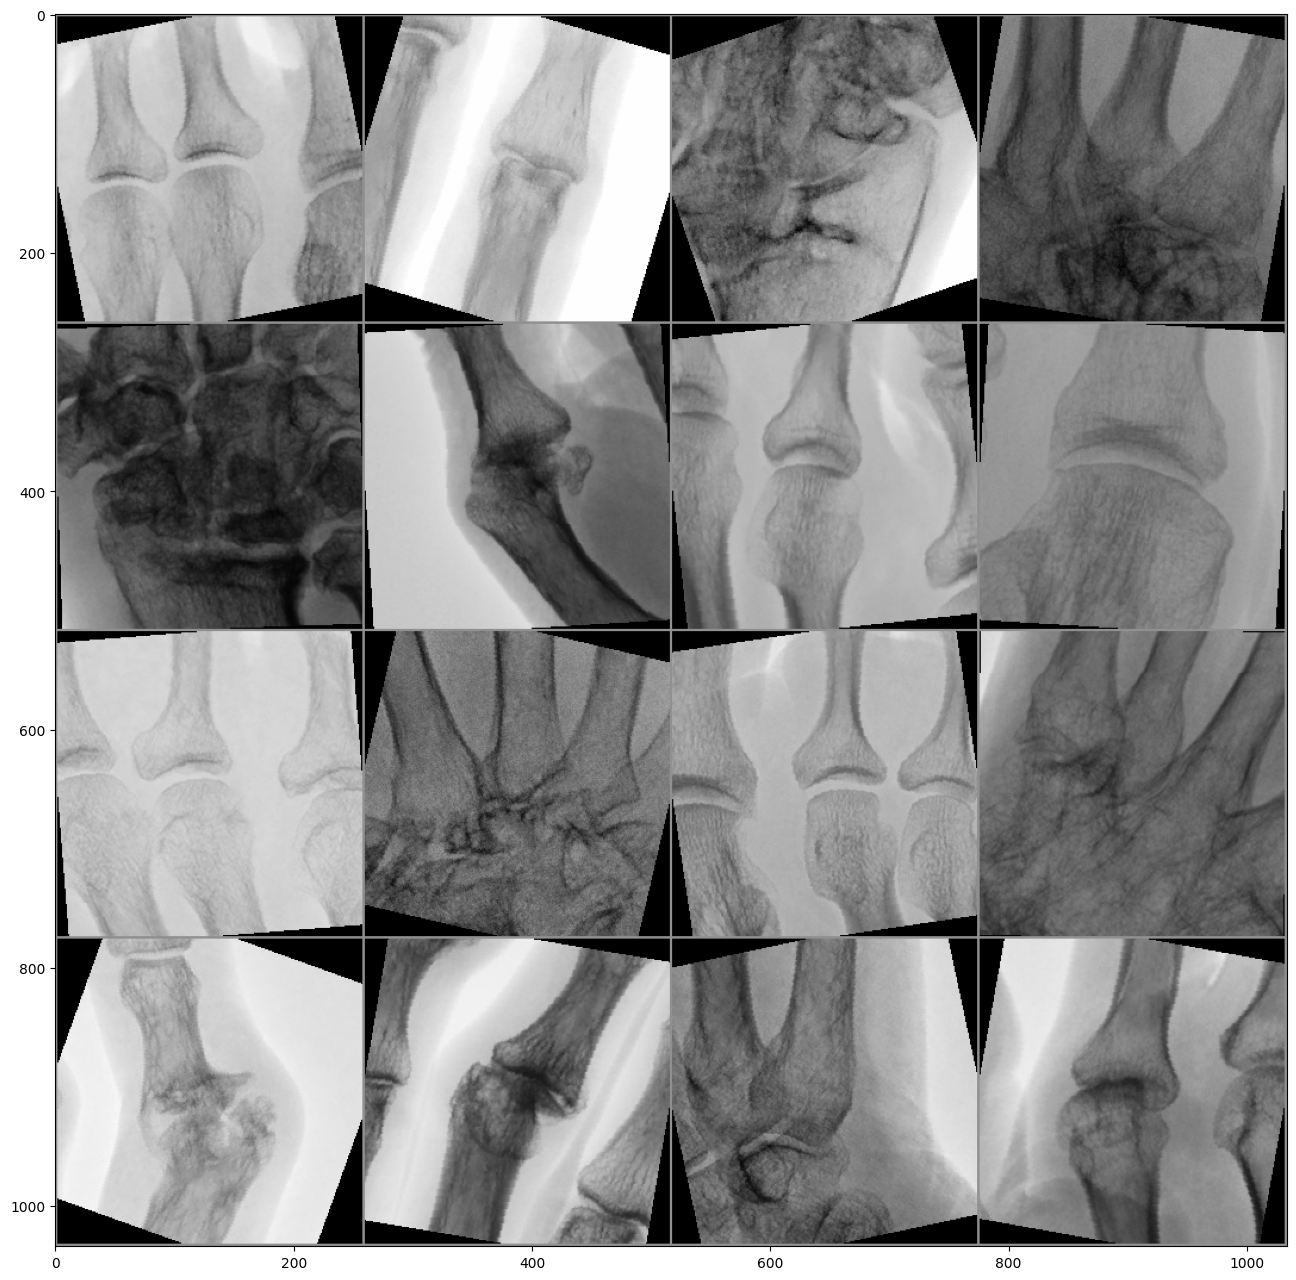

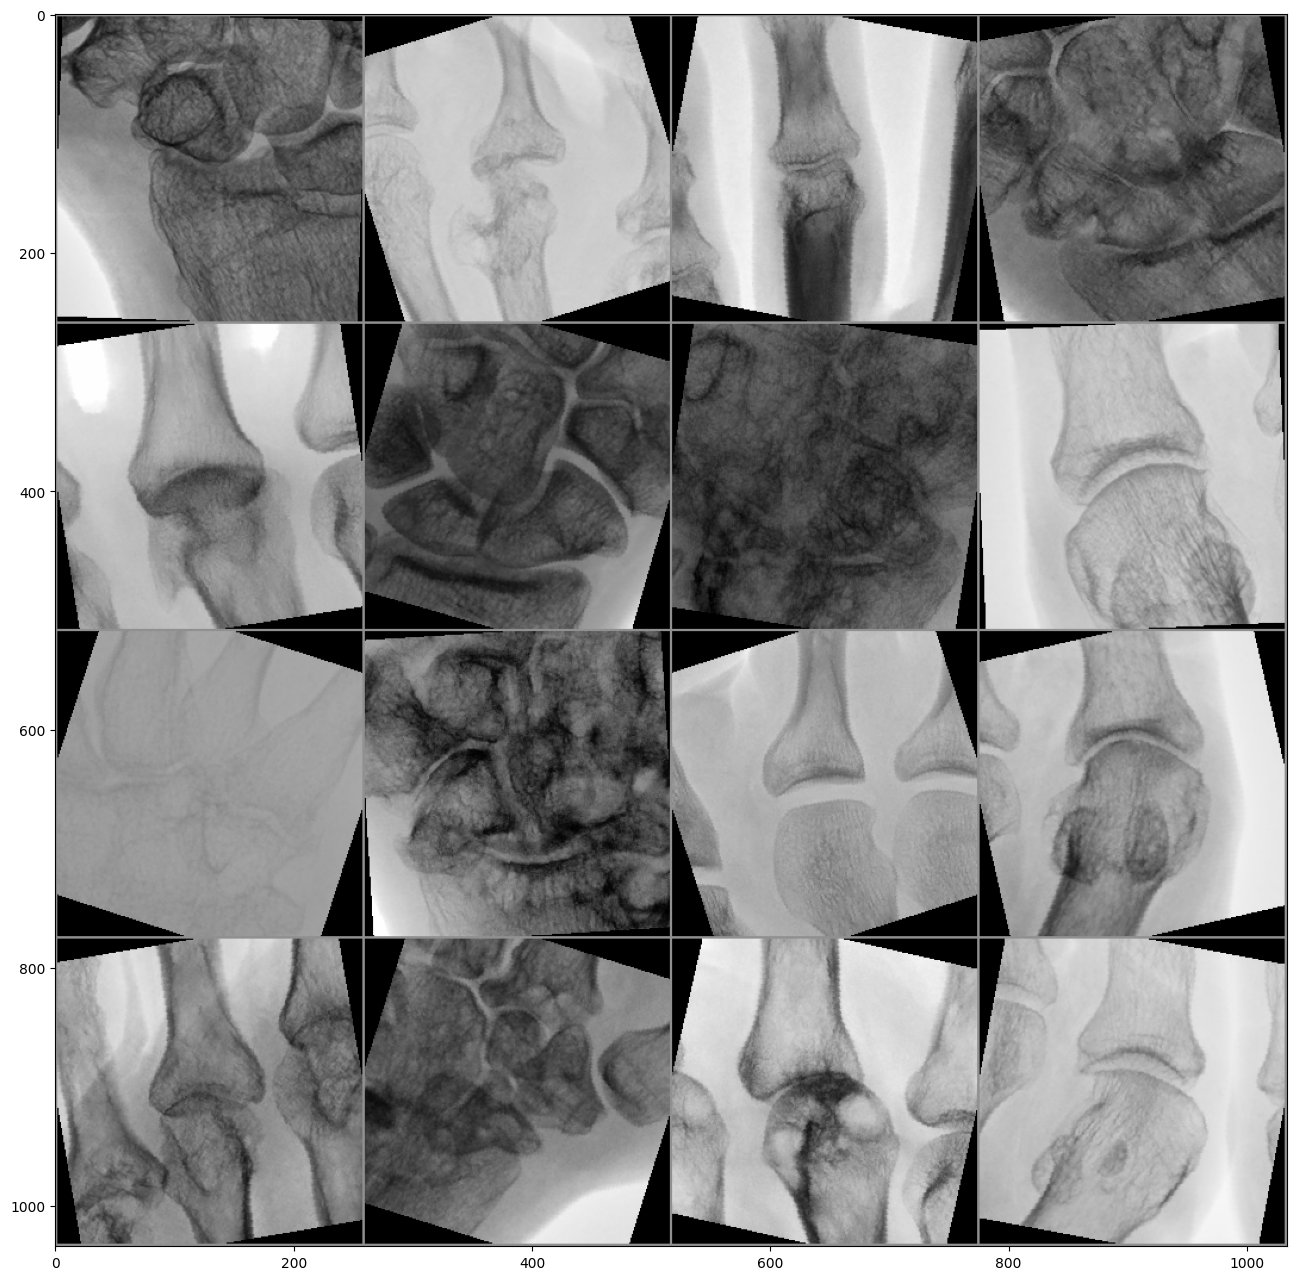

In [19]:
batchSize = 16

trainLoader = DataLoader(trainData, batch_size = batchSize, sampler=train_sampler, num_workers = 0)
valLoader = DataLoader(valData, batch_size = batchSize, sampler=val_sampler, shuffle = False, num_workers = 0)

show_loaded_images(trainLoader , mean= mean, std = std)
show_loaded_images(valLoader , mean= mean, std = std)

Model component define

In [20]:
import torch.nn.functional as F
import math
from torch.nn.modules.utils import _pair

## DEBUG
batch_size = 5
in_channels = 3
h, w = 24, 24
x = torch.ones(batch_size, in_channels, h, w)
kh, kw = 3, 3  # kernel_size
dh, dw = 1, 1  # stride
x_windows = x.unfold(2, kh, dh).unfold(3, kw, dw)
x_windows = x_windows.contiguous().view(*x_windows.size()[:-2], -1)

out_channels = 2
weights = torch.randn(1, out_channels, in_channels, *x_windows.size()[2:])
output = (x_windows.unsqueeze(1) * weights).sum([2, -1])
## DEBUG

class LocallyConnected2d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride, bias=False):
        super(LocallyConnected2d, self).__init__()
        output_size = _pair(output_size)
        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, output_size[0], output_size[1], kernel_size**2)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.randn(1, out_channels, output_size[0], output_size[1])
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)

    def forward(self, x):
        _, c, h, w = x.size()
        kh, kw = self.kernel_size
        dh, dw = self.stride
        x = x.unfold(2, kh, dh).unfold(3, kw, dw)
        x = x.contiguous().view(*x.size()[:-2], -1)
        # Sum in in_channel and kernel_size dims
        out = (x.unsqueeze(1) * self.weight).sum([2, -1])
        if self.bias is not None:
            out += self.bias
        return out

# Create input
batch_size = 5
in_channels = 3
h, w = 24, 24
x = torch.randn(batch_size, in_channels, h, w)

# Create layer and test if backpropagation works
out_channels = 2
output_size = 22
kernel_size = 3
stride = 1
conv = LocallyConnected2d(
    in_channels, out_channels, output_size, kernel_size, stride, bias=True)

out = conv(x)
out.mean().backward()

In [21]:
# model_name = 'efficientnet_v2_l'
# model = models.efficientnet_v2_l(weights = 'DEFAULT')

# # Modifying final classifier layer
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
# print(model.features[0])
# # print(model.classifier[1].in_features)

Attention layer

In [22]:
# import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import Conv2d, AdaptiveAvgPool2d, Linear

class AttentionModule(nn.Module):
    def __init__(self, in_channels, pt_depth):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=1 )
        self.conv2 = nn.Conv2d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=1 )
        self.conv4 = nn.Conv2d(128, 64, kernel_size=1 )
        self.conv5 = nn.Conv2d(64, 16, kernel_size=1 )
        self.conv6 = nn.Conv2d(16, 1, kernel_size=1)
        self.up_c2 = nn.Conv2d(1, pt_depth, kernel_size=1, bias=False)
        self.up_c2.weight = nn.Parameter(torch.ones((pt_depth, 1, 1, 1)), requires_grad=False)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.softmax(self.conv6(x), dim=-1)
        # x = self.conv6(x)
        x = self.up_c2(x)
        return x

class EfficientNetWithAttention(nn.Module):
    def __init__(self, num_classes=3):
        super(EfficientNetWithAttention, self).__init__()
        base_model = models.efficientnet_v2_l(weights='IMAGENET1K_V1')
        pt_depth = base_model.classifier[1].in_features
        self.base_model = nn.Sequential(*list(base_model.children())[:-2])  # 移除原有的分类器层

        self.attention_module = AttentionModule(pt_depth, pt_depth)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(pt_depth, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        features = self.base_model(x)
        attention_weights = self.attention_module(features)
        mask_features = features * attention_weights
        gap_features = self.global_avg_pool(mask_features)
        gap_mask = self.global_avg_pool(attention_weights)
        gap = gap_features / gap_mask
        gap = gap.view(gap.size(0), -1)
        x = self.dropout(F.relu(self.fc1(gap)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# 创建模型实例
model_name = 'efficientnet_v2_l'
model = EfficientNetWithAttention(num_classes=3)
# print(model)


Data Parallelism

In [23]:
model = nn.DataParallel(model).to(device)

In [24]:
# Defining the loss, optimizer, and annealer
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=5, verbose=True, threshold = 0.001, cooldown = 5, min_lr= 1e-9)

Early Stopping

In [39]:
patience = 30
minDelta = 0
currentPatience = 0
bestLoss = float('inf')

In [40]:
first_batch = next(iter(trainLoader))
inputs, labels = first_batch
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

print('lable: ', labels)


Inputs shape: torch.Size([16, 3, 256, 256])
Labels shape: torch.Size([16])
lable:  tensor([0, 0, 1, 1, 0, 2, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0])


Training Model

In [41]:
# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
valLosses = []
valAccs = []

# Training loop
epochs = 50
correct = total = 0
print('we are going to start our trainning')
for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0
    print(f'now we were in epoch {epoch+1}...')
    # 打印出當前的學習率
    current_lr = optimizer.param_groups[0]['lr']  # 假設你只有一個參數群組
    print(f'Current learning rate: {current_lr}')
    ttotal = tcorrect = 0
    progress_bar = tqdm(enumerate(trainLoader), total=len(trainLoader), desc=f"Epoch {epoch+1}/{epochs}")
    for batch_idx, (inputs, labels) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # 使用類別概率分佈計算損失
            _, predicted = torch.max(outputs, 1)
            ttotal += labels.size(0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

        
        tcorrect += (predicted == labels).sum().item()  # 注意：這裡將 labels 轉換為長整型張量

        # # 计算所有类别的概率（使用softmax）
        # probabilities = F.softmax(outputs, dim=1)

        # # 检查标签为2的样本，并输出这些样本的类别2的预测概率
        # for label, probability in zip(labels, probabilities):
        #     if label.item() == 2:  # 假设类别2是我们感兴趣的类别
        #         print(f"Label: 2, Predicted probability for class 2: {probability[2].item()}")


        progress_bar.set_postfix(trainloss=runningLoss/(batch_idx+1), accuracy=(100.*tcorrect)/ttotal)

    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.5f}')
    trainLosses.append(trainLoss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            #inputs = valTransformer(inputs)  # 將驗證集的資料進行轉換

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # 注意：這裡將 labels 轉換為長整型張量

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Best loss : {bestLoss:.5f} Validation Loss : {avgLoss:.5f} Validation Accuracy : {accuracy:.5f}%\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            print(f'--------------- new best loss : {bestLoss}')
            torch.save(model.state_dict(), f'hand_triple_model_weights_{model_name}_256_best_acc.pth')
            currentPatience = 0
        else:
            currentPatience += 1
            print('currentPatience: ', currentPatience)
            if currentPatience >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step(avgLoss)



we are going to start our trainning
now we were in epoch 1...
Current learning rate: 0.00027


Epoch 1/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.11it/s, accuracy=99.4, trainloss=0.0191]


Epoch 1/50 - Training Loss : 0.01914
Best loss : inf Validation Loss : 0.55025 Validation Accuracy : 89.86587%

--------------- new best loss : 0.5502546248026192
now we were in epoch 2...
Current learning rate: 0.00027


Epoch 2/50: 100%|████████████████████████████████████| 168/168 [00:54<00:00,  3.10it/s, accuracy=99.6, trainloss=0.015]


Epoch 2/50 - Training Loss : 0.01499
Best loss : 0.55025 Validation Loss : 0.62045 Validation Accuracy : 88.97168%

currentPatience:  1
now we were in epoch 3...
Current learning rate: 0.00027


Epoch 3/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.7, trainloss=0.0142]


Epoch 3/50 - Training Loss : 0.01419
Best loss : 0.55025 Validation Loss : 0.58889 Validation Accuracy : 89.12072%

currentPatience:  2
now we were in epoch 4...
Current learning rate: 0.00027


Epoch 4/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.2, trainloss=0.0202]


Epoch 4/50 - Training Loss : 0.02021
Best loss : 0.55025 Validation Loss : 0.45100 Validation Accuracy : 90.61103%

--------------- new best loss : 0.4510044811530471
now we were in epoch 5...
Current learning rate: 0.00027


Epoch 5/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.4, trainloss=0.0194]


Epoch 5/50 - Training Loss : 0.01943
Best loss : 0.45100 Validation Loss : 0.78155 Validation Accuracy : 87.03428%

currentPatience:  1
now we were in epoch 6...
Current learning rate: 8.1e-05


Epoch 6/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.4, trainloss=0.0165]


Epoch 6/50 - Training Loss : 0.01646
Best loss : 0.45100 Validation Loss : 0.55634 Validation Accuracy : 90.16393%

currentPatience:  2
now we were in epoch 7...
Current learning rate: 8.1e-05


Epoch 7/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.7, trainloss=0.0133]


Epoch 7/50 - Training Loss : 0.01332
Best loss : 0.45100 Validation Loss : 0.72372 Validation Accuracy : 88.82265%

currentPatience:  3
now we were in epoch 8...
Current learning rate: 8.1e-05


Epoch 8/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.3, trainloss=0.0184]


Epoch 8/50 - Training Loss : 0.01840
Best loss : 0.45100 Validation Loss : 0.69548 Validation Accuracy : 88.67362%

currentPatience:  4
now we were in epoch 9...
Current learning rate: 8.1e-05


Epoch 9/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.4, trainloss=0.0177]


Epoch 9/50 - Training Loss : 0.01767
Best loss : 0.45100 Validation Loss : 0.67545 Validation Accuracy : 88.52459%

currentPatience:  5
now we were in epoch 10...
Current learning rate: 8.1e-05


Epoch 10/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.09it/s, accuracy=99.4, trainloss=0.0161]


Epoch 10/50 - Training Loss : 0.01615
Best loss : 0.45100 Validation Loss : 0.51855 Validation Accuracy : 89.12072%

currentPatience:  6
now we were in epoch 11...
Current learning rate: 8.1e-05


Epoch 11/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.6, trainloss=0.0142]


Epoch 11/50 - Training Loss : 0.01415
Best loss : 0.45100 Validation Loss : 0.60973 Validation Accuracy : 89.56781%

currentPatience:  7
now we were in epoch 12...
Current learning rate: 8.1e-05


Epoch 12/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.5, trainloss=0.0168]


Epoch 12/50 - Training Loss : 0.01678
Best loss : 0.45100 Validation Loss : 0.65913 Validation Accuracy : 87.92846%

currentPatience:  8
now we were in epoch 13...
Current learning rate: 8.1e-05


Epoch 13/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.15it/s, accuracy=99.6, trainloss=0.0137]


Epoch 13/50 - Training Loss : 0.01373
Best loss : 0.45100 Validation Loss : 0.43647 Validation Accuracy : 91.95231%

--------------- new best loss : 0.436473547982695
now we were in epoch 14...
Current learning rate: 8.1e-05


Epoch 14/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.6, trainloss=0.0127]


Epoch 14/50 - Training Loss : 0.01266
Best loss : 0.43647 Validation Loss : 0.58409 Validation Accuracy : 89.41878%

currentPatience:  1
now we were in epoch 15...
Current learning rate: 8.1e-05


Epoch 15/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.3, trainloss=0.016]


Epoch 15/50 - Training Loss : 0.01604
Best loss : 0.43647 Validation Loss : 0.73568 Validation Accuracy : 85.99106%

currentPatience:  2
now we were in epoch 16...
Current learning rate: 8.1e-05


Epoch 16/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.6, trainloss=0.014]


Epoch 16/50 - Training Loss : 0.01404
Best loss : 0.43647 Validation Loss : 0.78522 Validation Accuracy : 88.07750%

currentPatience:  3
now we were in epoch 17...
Current learning rate: 2.43e-05


Epoch 17/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.7, trainloss=0.0113]


Epoch 17/50 - Training Loss : 0.01131
Best loss : 0.43647 Validation Loss : 0.65656 Validation Accuracy : 89.12072%

currentPatience:  4
now we were in epoch 18...
Current learning rate: 2.43e-05


Epoch 18/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.11it/s, accuracy=99.4, trainloss=0.0166]


Epoch 18/50 - Training Loss : 0.01660
Best loss : 0.43647 Validation Loss : 0.72474 Validation Accuracy : 88.67362%

currentPatience:  5
now we were in epoch 19...
Current learning rate: 2.43e-05


Epoch 19/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.6, trainloss=0.0153]


Epoch 19/50 - Training Loss : 0.01531
Best loss : 0.43647 Validation Loss : 0.63955 Validation Accuracy : 90.01490%

currentPatience:  6
now we were in epoch 20...
Current learning rate: 2.43e-05


Epoch 20/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.07it/s, accuracy=99.7, trainloss=0.0116]


Epoch 20/50 - Training Loss : 0.01155
Best loss : 0.43647 Validation Loss : 0.69460 Validation Accuracy : 87.77943%

currentPatience:  7
now we were in epoch 21...
Current learning rate: 2.43e-05


Epoch 21/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.6, trainloss=0.0136]


Epoch 21/50 - Training Loss : 0.01364
Best loss : 0.43647 Validation Loss : 0.52395 Validation Accuracy : 90.46200%

currentPatience:  8
now we were in epoch 22...
Current learning rate: 2.43e-05


Epoch 22/50: 100%|███████████████████████████████████| 168/168 [00:54<00:00,  3.10it/s, accuracy=99.7, trainloss=0.012]


Epoch 22/50 - Training Loss : 0.01202
Best loss : 0.43647 Validation Loss : 0.61937 Validation Accuracy : 90.46200%

currentPatience:  9
now we were in epoch 23...
Current learning rate: 2.43e-05


Epoch 23/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.3, trainloss=0.0178]


Epoch 23/50 - Training Loss : 0.01784
Best loss : 0.43647 Validation Loss : 0.56591 Validation Accuracy : 88.82265%

currentPatience:  10
now we were in epoch 24...
Current learning rate: 2.43e-05


Epoch 24/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.4, trainloss=0.0184]


Epoch 24/50 - Training Loss : 0.01838
Best loss : 0.43647 Validation Loss : 0.53360 Validation Accuracy : 89.41878%

currentPatience:  11
now we were in epoch 25...
Current learning rate: 2.43e-05


Epoch 25/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.4, trainloss=0.0143]


Epoch 25/50 - Training Loss : 0.01431
Best loss : 0.43647 Validation Loss : 0.74672 Validation Accuracy : 89.71684%

currentPatience:  12
now we were in epoch 26...
Current learning rate: 2.43e-05


Epoch 26/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.10it/s, accuracy=99.6, trainloss=0.0112]


Epoch 26/50 - Training Loss : 0.01116
Best loss : 0.43647 Validation Loss : 0.47889 Validation Accuracy : 90.31297%

currentPatience:  13
now we were in epoch 27...
Current learning rate: 2.43e-05


Epoch 27/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.4, trainloss=0.0147]


Epoch 27/50 - Training Loss : 0.01474
Best loss : 0.43647 Validation Loss : 0.50029 Validation Accuracy : 90.16393%

currentPatience:  14
now we were in epoch 28...
Current learning rate: 7.29e-06


Epoch 28/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.11it/s, accuracy=99.5, trainloss=0.0167]


Epoch 28/50 - Training Loss : 0.01669
Best loss : 0.43647 Validation Loss : 0.46424 Validation Accuracy : 90.61103%

currentPatience:  15
now we were in epoch 29...
Current learning rate: 7.29e-06


Epoch 29/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.12it/s, accuracy=99.6, trainloss=0.0126]


Epoch 29/50 - Training Loss : 0.01259
Best loss : 0.43647 Validation Loss : 0.62663 Validation Accuracy : 89.71684%

currentPatience:  16
now we were in epoch 30...
Current learning rate: 7.29e-06


Epoch 30/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.11it/s, accuracy=99.6, trainloss=0.0143]


Epoch 30/50 - Training Loss : 0.01434
Best loss : 0.43647 Validation Loss : 0.56056 Validation Accuracy : 91.65425%

currentPatience:  17
now we were in epoch 31...
Current learning rate: 7.29e-06


Epoch 31/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.5, trainloss=0.0145]


Epoch 31/50 - Training Loss : 0.01448
Best loss : 0.43647 Validation Loss : 0.61211 Validation Accuracy : 89.71684%

currentPatience:  18
now we were in epoch 32...
Current learning rate: 7.29e-06


Epoch 32/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.11it/s, accuracy=99.6, trainloss=0.0129]


Epoch 32/50 - Training Loss : 0.01292
Best loss : 0.43647 Validation Loss : 0.67525 Validation Accuracy : 88.52459%

currentPatience:  19
now we were in epoch 33...
Current learning rate: 7.29e-06


Epoch 33/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.6, trainloss=0.0129]


Epoch 33/50 - Training Loss : 0.01290
Best loss : 0.43647 Validation Loss : 0.62803 Validation Accuracy : 88.82265%

currentPatience:  20
now we were in epoch 34...
Current learning rate: 7.29e-06


Epoch 34/50: 100%|█████████████████████████████████| 168/168 [00:54<00:00,  3.10it/s, accuracy=99.7, trainloss=0.00916]


Epoch 34/50 - Training Loss : 0.00916
Best loss : 0.43647 Validation Loss : 0.63966 Validation Accuracy : 89.12072%

currentPatience:  21
now we were in epoch 35...
Current learning rate: 7.29e-06


Epoch 35/50: 100%|██████████████████████████████████| 168/168 [00:55<00:00,  3.05it/s, accuracy=99.4, trainloss=0.0172]


Epoch 35/50 - Training Loss : 0.01715
Best loss : 0.43647 Validation Loss : 0.70301 Validation Accuracy : 87.63040%

currentPatience:  22
now we were in epoch 36...
Current learning rate: 7.29e-06


Epoch 36/50: 100%|██████████████████████████████████| 168/168 [00:53<00:00,  3.13it/s, accuracy=99.2, trainloss=0.0208]


Epoch 36/50 - Training Loss : 0.02081
Best loss : 0.43647 Validation Loss : 0.73662 Validation Accuracy : 87.77943%

currentPatience:  23
now we were in epoch 37...
Current learning rate: 7.29e-06


Epoch 37/50: 100%|███████████████████████████████████| 168/168 [00:53<00:00,  3.14it/s, accuracy=99.7, trainloss=0.011]


Epoch 37/50 - Training Loss : 0.01105
Best loss : 0.43647 Validation Loss : 0.64862 Validation Accuracy : 88.67362%

currentPatience:  24
now we were in epoch 38...
Current learning rate: 7.29e-06


Epoch 38/50: 100%|██████████████████████████████████| 168/168 [00:54<00:00,  3.11it/s, accuracy=99.4, trainloss=0.0179]


Epoch 38/50 - Training Loss : 0.01790
Best loss : 0.43647 Validation Loss : 0.62784 Validation Accuracy : 89.12072%

currentPatience:  25
now we were in epoch 39...
Current learning rate: 2.187e-06


Epoch 39/50: 100%|██████████████████████████████████| 168/168 [00:55<00:00,  3.00it/s, accuracy=99.6, trainloss=0.0126]


Epoch 39/50 - Training Loss : 0.01257
Best loss : 0.43647 Validation Loss : 0.57150 Validation Accuracy : 89.41878%

currentPatience:  26
now we were in epoch 40...
Current learning rate: 2.187e-06


Epoch 40/50: 100%|██████████████████████████████████| 168/168 [00:57<00:00,  2.94it/s, accuracy=99.7, trainloss=0.0104]


Epoch 40/50 - Training Loss : 0.01036
Best loss : 0.43647 Validation Loss : 0.52268 Validation Accuracy : 90.01490%

currentPatience:  27
now we were in epoch 41...
Current learning rate: 2.187e-06


Epoch 41/50: 100%|██████████████████████████████████| 168/168 [00:57<00:00,  2.93it/s, accuracy=99.7, trainloss=0.0104]


Epoch 41/50 - Training Loss : 0.01038
Best loss : 0.43647 Validation Loss : 0.63897 Validation Accuracy : 89.12072%

currentPatience:  28
now we were in epoch 42...
Current learning rate: 2.187e-06


Epoch 42/50: 100%|██████████████████████████████████| 168/168 [00:57<00:00,  2.91it/s, accuracy=99.6, trainloss=0.0147]


Epoch 42/50 - Training Loss : 0.01474
Best loss : 0.43647 Validation Loss : 0.49412 Validation Accuracy : 91.20715%

currentPatience:  29
now we were in epoch 43...
Current learning rate: 2.187e-06


Epoch 43/50: 100%|██████████████████████████████████| 168/168 [00:57<00:00,  2.94it/s, accuracy=99.6, trainloss=0.0129]


Epoch 43/50 - Training Loss : 0.01293
Best loss : 0.43647 Validation Loss : 0.62484 Validation Accuracy : 88.22653%

currentPatience:  30
Early stopping triggered.


Plotting

In [42]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(now)
torch.save(model.state_dict(), f'hand_triple_model_weights_{model_name}_{imgSize}_{now}.pth')

2024-03-11_02-52-32


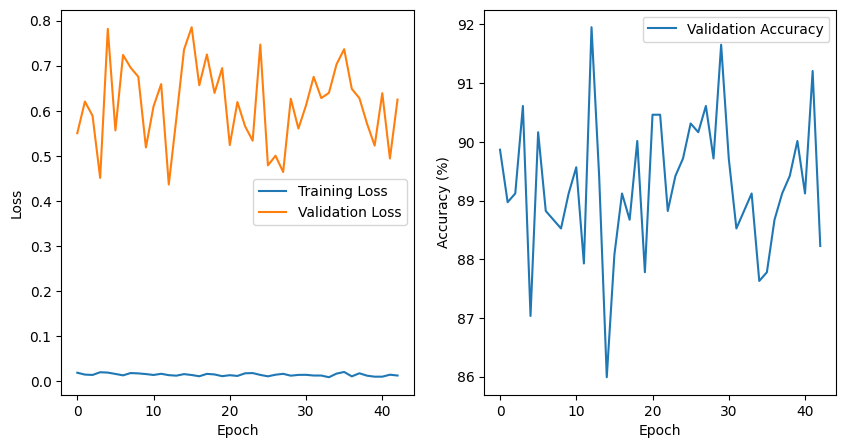

In [43]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       209
           1       0.86      0.74      0.80       196
           2       0.82      0.89      0.86       266

    accuracy                           0.88       671
   macro avg       0.89      0.88      0.88       671
weighted avg       0.88      0.88      0.88       671



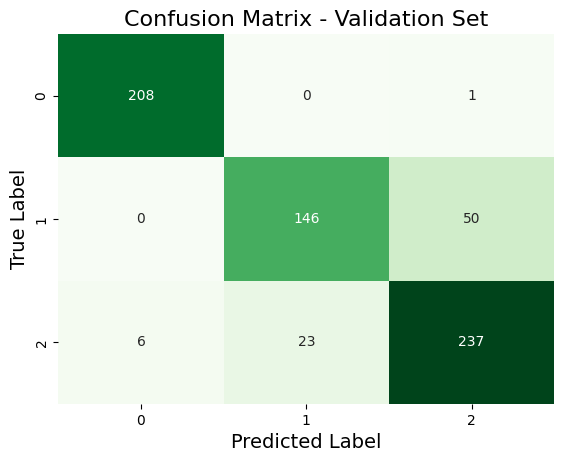

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       209
           1       0.86      0.74      0.80       196
           2       0.82      0.89      0.86       266

    accuracy                           0.88       671
   macro avg       0.89      0.88      0.88       671
weighted avg       0.88      0.88      0.88       671



In [48]:
model.load_state_dict(torch.load('./hand_triple_model_weights_efficientnet_v2_l_256_best_acc.pth'))

# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze()

        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)  # 將模型的輸出通過 softmax 函數
        predictions = torch.argmax(outputs, dim=1)  # 從概率分佈中取最大值作為預測結果


        # 检查标签为2的样本，并输出这些样本的类别2的预测概率
        for label, probability in zip(labels, probabilities):
            if label.item() == 2:  # 假设类别2是我们感兴趣的类别
                # print(f"Label: 2, Predicted probability for class 2: {probability[2].item()}")
                pass

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

from sklearn.metrics import classification_report

report = classification_report(allLabels, allPreds, target_names=['0', '1', '2'])

print(report)
matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = ['0','1','2'], yticklabels = ['0','1','2'], cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

print(report)